# Leash Bio

- positive data多めに使う。残りはrandom sampling
- bbごとにsoft labelingしてみる


## ref
- https://www.kaggle.com/code/yyyu54/pytorch-version-belka-1dcnn-starter-with-all-data
- https://www.kaggle.com/code/ahmedelfazouan/belka-1dcnn-starter-with-all-data/notebook

In [1]:
exp_no = '000'
DEBUG = False
# data_ratio = 1/5

In [2]:
import gc
import os
import pickle
import random
import joblib
import pandas as pd
# import polars as pd
from tqdm import tqdm

import numpy as np
from sklearn.metrics import average_precision_score as APS
from sklearn.model_selection import StratifiedKFold

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor

from pytorch_lightning import LightningModule
from pytorch_lightning import LightningDataModule, Trainer
# seed_everything
from pytorch_lightning.callbacks import (
    ModelCheckpoint, 
    EarlyStopping,
    ModelCheckpoint,
    RichModelSummary,
    RichProgressBar,
)
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import timm
from timm.utils import ModelEmaV2

from funcs.utils import find_latest_ckpt_path, del_old_ckpt_path
from funcs.calc_descriptor import calc_rdkit_descriptors, calc_ecfp4_descriptors
from funcs.tokenize import tokenize_smiles

import warnings
warnings.simplefilter('ignore')

In [3]:
import os
from pathlib import Path

def is_kaggle_kernel():
    return os.path.exists('/kaggle/working')

if is_kaggle_kernel():

    BASE_DIR = Path("/kaggle")
    DATA_DIR = BASE_DIR / "input"
    OUTPUT_DIR = BASE_DIR / "working"
    print('on kaggle notebook')

else:
    BASE_DIR = Path(os.getcwd()) / './../'
    DATA_DIR = BASE_DIR / "data"
    OUTPUT_DIR = BASE_DIR / f"output/exp{exp_no}"
    
# set device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():    
    device = "cuda"
else:
    device = "cpu"
    
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print('Using', torch.cuda.device_count(), 'GPU(s)')
print('pytorch:', torch.__version__)

Using 0 GPU(s)
pytorch: 2.3.1


In [4]:
class config:
    SEED = 2024
    
    PREPROCESS = False
    EPOCHS = 20 #20
    PATIENCE = 5 #20
    BATCH_SIZE = 4096
    NUM_WORKERS = 16
    
    USE_EMA = False
    
    LR = 1e-3
    WEIGHT_DECAY = 1e-6
    MIXED_PRECISION = True
    
    NUM_FOLDS = 5    
    USE_NUM_FOLD = 1
    
class paths:    
    DATA_DIR = DATA_DIR
    OUTPUT_DIR = OUTPUT_DIR
    MODEL_WEIGHTS_DIR = OUTPUT_DIR / f"bio-models-exp{exp_no}"
    
    SHRUNKEN_DATA_DIR = DATA_DIR / "shrunken-data"

    TRAIN_PATH = SHRUNKEN_DATA_DIR / "train.parquet"
    TEST_PATH = SHRUNKEN_DATA_DIR / "test.parquet"
    SUB_PATH = SHRUNKEN_DATA_DIR / "sub.parquet"
    
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [5]:
print('fix seed')

def my_seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
# seed_everything(config.SEED, workers=True)
my_seed_everything(config.SEED)

fix seed


# **Loda Data**

In [34]:
bb_cols = ['buildingblock1_smiles', 'buildingblock2_smiles','buildingblock3_smiles', 
           'buildingblock1_smiles_scaffold', "buildingblock2_smiles_scaffold", "buildingblock3_smiles_scaffold",
           'fold']

TARGETS = ['binds_BRD4', 'binds_HSA','binds_sEH']

df_train = pd.read_parquet(paths.TRAIN_PATH, columns=bb_cols + TARGETS)

In [80]:
# ソフトラベリングを用意する
bb1_mean = df_train.groupby('buildingblock1_smiles')[TARGETS].mean()
bb2_mean = df_train.groupby('buildingblock2_smiles')[TARGETS].mean()
bb3_mean = df_train.groupby('buildingblock3_smiles')[TARGETS].mean()

In [81]:
# 変換用辞書を読み込む
with open(paths.SHRUNKEN_DATA_DIR / 'bb1_smiles2idx.pickle', mode='rb') as f:
    bb1_smiles2idx = pickle.load(f)
with open(paths.SHRUNKEN_DATA_DIR / 'bb23_smiles2idx.pickle', mode='rb') as f:
    bb23_smiles2idx = pickle.load(f)
with open(paths.SHRUNKEN_DATA_DIR / 'bb1_scaffold_smiles2idx.pickle', mode='rb') as f:
    bb1_scaffold_smiles2idx = pickle.load(f)
with open(paths.SHRUNKEN_DATA_DIR / 'bb23_scaffold_smiles2idx.pickle', mode='rb') as f:
    bb23_scaffold_smiles2idx = pickle.load(f)
    
bb1_idx2smiles = {v:k for k,v in bb1_smiles2idx.items()}
bb23_idx2smiles = {v:k for k,v in bb23_smiles2idx.items()}
bb1_scaffold_idx2smiles = {v:k for k,v in bb1_scaffold_smiles2idx.items()}
bb23_scaffold_idx2smiles = {v:k for k,v in bb23_scaffold_smiles2idx.items()}

In [82]:
# すべて0のbbがあるかチェック

In [87]:
bb2_index_list = {}
bb3_index_list = {}

for col in TARGETS:
    index2_list = bb2_mean[bb2_mean[col]==0].index.tolist()
    bb2_index_list[col] = index2_list
    print(index2_list)

    index3_list = bb3_mean[bb3_mean[col]==0].index.tolist()
    bb3_index_list[col] = index3_list
    print(index3_list)
    
for col in TARGETS:
    index_temp = bb3_index_list[col]
    
    for index in index_temp:
        count = (df_train['buildingblock3_smiles']==index).sum()
        print(col, ":", index,":", count)

[]
[302, 387, 699, 799, 883, 928, 1028, 1160, 1207, 1226, 1301, 1311, 1331, 1377, 1379, 1411, 1414, 1458]
[1469]
[70, 228, 1226]
[]
[1226]
binds_BRD4 : 302 : 5674
binds_BRD4 : 387 : 10265
binds_BRD4 : 699 : 11345
binds_BRD4 : 799 : 23962
binds_BRD4 : 883 : 2162
binds_BRD4 : 928 : 1895
binds_BRD4 : 1028 : 792
binds_BRD4 : 1160 : 7295
binds_BRD4 : 1207 : 7566
binds_BRD4 : 1226 : 266
binds_BRD4 : 1301 : 6438
binds_BRD4 : 1311 : 14006
binds_BRD4 : 1331 : 30768
binds_BRD4 : 1377 : 1625
binds_BRD4 : 1379 : 8087
binds_BRD4 : 1411 : 995
binds_BRD4 : 1414 : 16501
binds_BRD4 : 1458 : 5134
binds_HSA : 70 : 43798
binds_HSA : 228 : 542
binds_HSA : 1226 : 266
binds_sEH : 1226 : 266


In [88]:
# 保存する
bb2_index_list

{'binds_BRD4': [], 'binds_HSA': [1469], 'binds_sEH': []}

# BB1のランキングを見る

In [16]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw


In [17]:

def show_mol(target, bb_col, df_mean, idx2smiles, top=True):
    rank = df_mean[target].sort_values(ascending=False).reset_index()
    rank[bb_col] = rank[bb_col].map(idx2smiles)

    smiles_list = rank[bb_col].values
    mols_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    score_list = [str(round(s,5)) for s in rank[target].values]

    # gridで描画
    if top:
        img = Draw.MolsToGridImage(mols_list[:20], molsPerRow=5, subImgSize=(200,200), legends=score_list[:20])
    else:
        img = Draw.MolsToGridImage(mols_list[-20:], molsPerRow=5, subImgSize=(200,200), legends=score_list[-20:])
    return img

## **building block1**

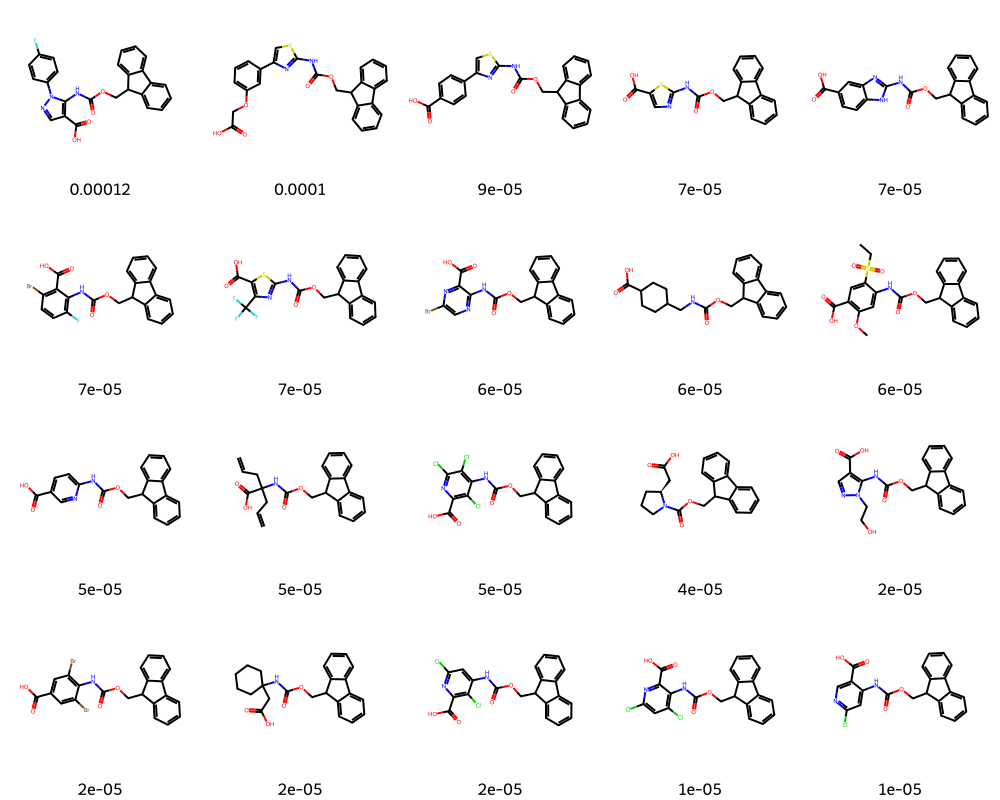

In [19]:
target = 'binds_BRD4'
# target = 'binds_HSA'
# target = 'binds_sEH'
bb_col = 'buildingblock1_smiles'
show_mol(target, bb_col, bb1_mean, bb1_idx2smiles, top=False)

## **building block2**

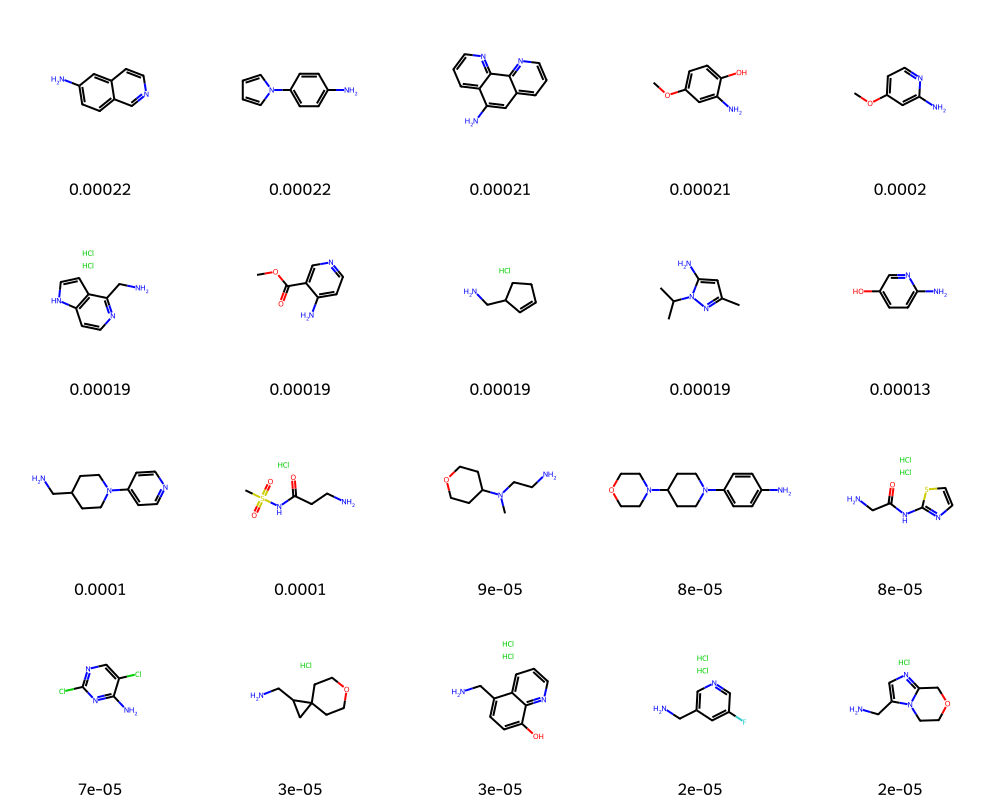

In [21]:
target = 'binds_BRD4'
# target = 'binds_HSA'
# target = 'binds_sEH'
bb_col = 'buildingblock2_smiles'
show_mol(target, bb_col, bb2_mean, bb23_idx2smiles, top=False)

In [22]:
## bb3

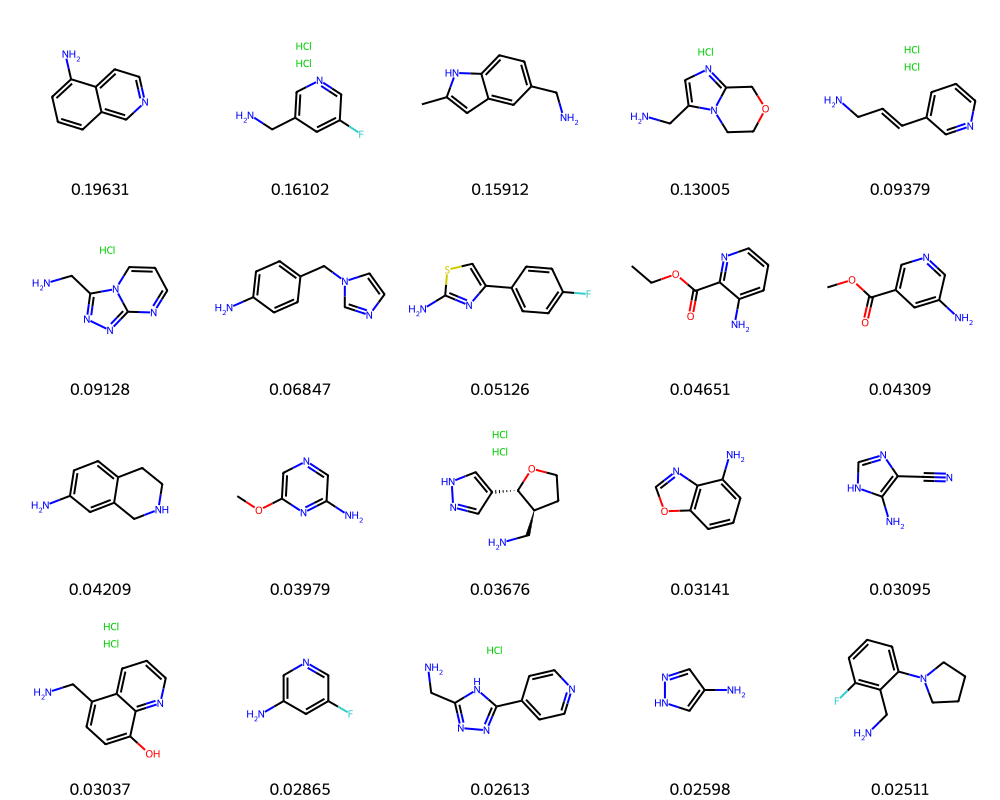

In [26]:
# target = 'binds_BRD4'
target = 'binds_HSA'
# target = 'binds_sEH'
bb_col = 'buildingblock3_smiles'
show_mol(target, bb_col, bb3_mean, bb23_idx2smiles, top=True)